In [1]:
# nb-lightfm.ipynb

# Importing the Necessary Libraries

In [2]:
import sys
import numpy as np
import pandas as pd
import multiprocessing
import time
import lightfm
import random
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k
from lightfm.cross_validation import random_train_test_split
from scipy import sparse
from settings import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from user_func import toratings

D:\Anaconda\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


.\cache\2019-Nov.csv
.\cache\2019-Oct.csv


In [3]:
print(f'System version:  {sys.version}')
print(f'Pandas version:  {pd.__version__}')
print(f'Numpy version:   {np.__version__}')
print(f'LightFM version: {lightfm.__version__}')

System version:  3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
Pandas version:  1.5.3
Numpy version:   1.23.5
LightFM version: 1.17


In [4]:
start_time = time.time()

In [5]:
%precision 2

'%.2f'

In [6]:
dataset = pd.read_pickle(ds_flt_file) # Полные данные после фильтрации
ds = pd.read_pickle(showcase_seg_file) # Сегментированная витрина
ds = ds[ds['Segment']==13]
df = toratings(ds, dataset)
#ds = ds['userID', 'category', 'rating']

In [7]:
#df.head()

# Function for Creating the Interaction Matrix

In [8]:
def create_interaction_matrix(df, user_col, item_col, rating_col, norm=False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - df = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output - 
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

# Interaction Matrix

In [9]:
#interactions = create_interaction_matrix(df_r, user_col = 'userID', item_col = 'itemID', rating_col = 'rating')

### Evaluate how well LightFM performs

In [10]:
K_NUM = 10
def check_method(interactions):
    x = sparse.csr_matrix(interactions.values)
    train, test = random_train_test_split(x, test_percentage=0.2, random_state=42)
    # Due to windows environment issue in v1.17 only default 'logistic' loss is working.
    model = LightFM(learning_rate=0.05, loss='logistic')
    model.fit(test, epochs = 300)

    train_precision = precision_at_k(model, train, k=K_NUM, num_threads=multiprocessing.cpu_count()).mean()
    test_precision = precision_at_k(model, test, k=K_NUM, num_threads=multiprocessing.cpu_count()).mean()

    train_auc = auc_score(model, train).mean()
    test_auc = auc_score(model, test).mean()

    print(f'Precision: train {train_precision:.2f}, test {test_precision:.2f}.')
    print(f'AUC: train {train_auc:.2f}, test {test_auc:.2f}.')
    return [train_precision, test_precision, train_auc, test_auc]

# Running the Model Function

In [11]:
def runMF(interactions, n_components=30, k=15, epoch = 300, n_jobs=1):
    '''
    Function to run matrix-factorization algorithm
    Required Input -
        - interactions = dataset create by create_interaction_matrix
        - n_components = number of embeddings you want to create to define Item and user
        - loss = loss function other options are logistic, brp
        - epoch = number of epochs to run 
        - n_jobs = number of cores used for execution 
    Expected Output  -h
        Model - Trained model
    '''
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(learning_rate=0.05, no_components = n_components, k = k)
    model.fit(x, epochs = epoch, num_threads = n_jobs)
    return model

In [12]:
#model = runMF(interactions, n_components = 30, k = 15, epoch = 100, n_jobs = 4)

# Creating the User and Item Dictionary

In [13]:
def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

In [14]:
#item_dict = create_item_dict(df_r,'itemID','category')

In [15]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [16]:
#user_dict = create_user_dict(interactions)

# Sample Recommendations

In [17]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
                       .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = set(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print(f'Рекомендовано: {scores}\nКуплено: {known_items}\n')
    return return_score_list

In [18]:
def show_recs(model):
    for user in random.sample(range(0, interactions.shape[0]), 2):
        print(f'Пользователь: {interactions.index[user]}')
        dummy = sample_recommendation_user(model, interactions, interactions.index[user], user_dict, 
                                   item_dict,threshold = 0, nrec_items = 3, show = True)

In [19]:
%%time
dataset = pd.read_pickle(ds_flt_file) # Полные данные после фильтрации
ds = pd.read_pickle(showcase_seg_file) # Сегментированная витрина

CPU times: total: 1.92 s
Wall time: 1.95 s


In [20]:
last_model = []

In [21]:
for seg in set(ds['Segment']):
    print(f'\nСегмент: {seg}')

    df = toratings(ds[ds['Segment']==seg], dataset)
    df_r=df[["userID","itemID","rating","category"]]
    item_dict = create_item_dict(df_r,'itemID','category')
    interactions = create_interaction_matrix(df_r, user_col = 'userID', item_col = 'itemID', rating_col = 'rating')
    user_dict = create_user_dict(interactions)
    model = runMF(interactions, n_components = 30, k = K_NUM, epoch = 300)
    show_recs(model)
    print('='*80)
    #check_method(interactions)
    last_model = model


Сегмент: 0
Пользователь: 517080137
Рекомендовано: ['water_heater', 'notebook', 'desktop']
Куплено: {'subwoofer'}

Пользователь: 533096777
Рекомендовано: ['subwoofer', 'water_heater', 'notebook']
Куплено: {'kettle', 'microwave'}


Сегмент: 1
Пользователь: 552033065
Рекомендовано: ['shoes', 'kettle', 'desktop']
Куплено: {'tv', 'blender'}

Пользователь: 530393975
Рекомендовано: ['shoes', 'desktop', 'blender']
Куплено: {'kettle'}


Сегмент: 2
Пользователь: 559073889
Рекомендовано: ['headphone', 'hdd', 'monitor']
Куплено: {'mouse', 'keyboard'}

Пользователь: 561868975
Рекомендовано: ['hdd', 'monitor', 'headphone']
Куплено: {'ironing_board'}


Сегмент: 3
Пользователь: 550704779
Рекомендовано: ['headphone', 'clocks', 'notebook']
Куплено: {'tv'}

Пользователь: 539002504
Рекомендовано: ['tv', 'clocks', 'notebook']
Куплено: {'headphone'}


Сегмент: 4
Пользователь: 560003423
Рекомендовано: ['hob', 'oven', 'hood']
Куплено: {'grill', 'blender'}

Пользователь: 512580994
Рекомендовано: ['hob', 'oven

In [22]:
%precision 2
grdata = []
for seg in set(ds['Segment']):
    print(f'Segment: {seg}')
    df = toratings(ds[ds['Segment']==seg], dataset)
    df_r=df[["userID","itemID","rating","category"]]
    item_dict = create_item_dict(df_r,'itemID','category')
    interactions = create_interaction_matrix(df_r, user_col = 'userID', item_col = 'itemID', rating_col = 'rating')
    ret = check_method(interactions)
    grdata.append(ret)
    print()

Segment: 0
Precision: train 0.13, test 0.12.
AUC: train 0.91, test 0.97.

Segment: 1
Precision: train 0.10, test 0.10.
AUC: train 0.84, test 0.95.

Segment: 2
Precision: train 0.15, test 0.12.
AUC: train 0.83, test 0.96.

Segment: 3
Precision: train 0.12, test 0.10.
AUC: train 0.88, test 0.88.

Segment: 4
Precision: train 0.12, test 0.11.
AUC: train 0.83, test 0.96.

Segment: 5
Precision: train 0.16, test 0.12.
AUC: train 0.81, test 0.96.

Segment: 6
Precision: train 0.13, test 0.11.
AUC: train 0.85, test 0.84.

Segment: 7
Precision: train 0.12, test 0.11.
AUC: train 0.84, test 0.95.

Segment: 8
Precision: train 0.13, test 0.11.
AUC: train 0.85, test 0.95.

Segment: 9
Precision: train 0.12, test 0.12.
AUC: train 0.73, test 0.94.

Segment: 10
Precision: train 0.08, test 0.12.
AUC: train 0.73, test 0.97.

Segment: 11
Precision: train 0.13, test 0.11.
AUC: train 0.86, test 0.95.

Segment: 12
Precision: train 0.11, test 0.11.
AUC: train 0.90, test 0.97.



In [23]:
df = pd.DataFrame(grdata, columns=['train_precision', 'test_precision', 'train_auc', 'test_auc'])

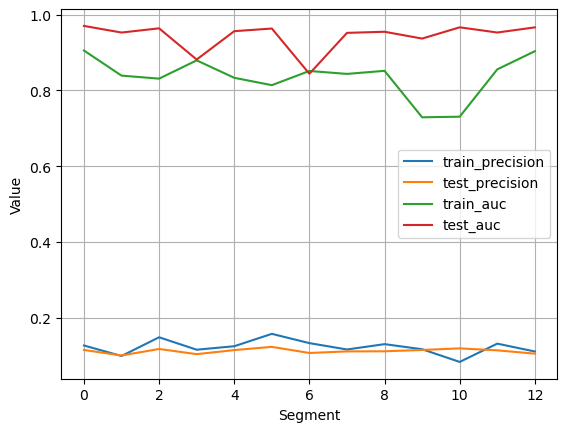

In [24]:
df.plot(xlabel='Segment', ylabel='Value', grid=True);

In [25]:
pd.set_option("display.precision", 2)
df.index.name = 'Segment'

In [26]:
from user_func import prdf
print('Метрики ранжирования')
prdf(df.T)
print('Finish')
for col in df.columns:
    print(col,df[col].mean())

Метрики ранжирования


Segment,0,1,2,3,4,5,6,7,8,9,10,11,12
train_precision,0.13,0.10,0.15,0.12,0.12,0.16,0.13,0.12,0.13,0.12,0.08,0.13,0.11
test_precision,0.12,0.10,0.12,0.10,0.11,0.12,0.11,0.11,0.11,0.12,0.12,0.11,0.11
train_auc,0.91,0.84,0.83,0.88,0.83,0.81,0.85,0.84,0.85,0.73,0.73,0.86,0.90
test_auc,0.97,0.95,0.96,0.88,0.96,0.96,0.84,0.95,0.95,0.94,0.97,0.95,0.97


Finish
train_precision 0.12282416
test_precision 0.11228744
train_auc 0.8359999
test_auc 0.94321513


In [27]:
seconds = int(time.time() - start_time)
print("%d:%02d" % (seconds // 60, seconds - 60 * (seconds // 60),))

0:50
